<a href="https://colab.research.google.com/github/akritidu/Multi-label-Classification-in-the-Home-Improvement/blob/main/LSTM_Bi_LSTM_GRU_Bi_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Uploading and Cleaning 

In [2]:

from numpy import array
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, LSTM, GRU, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.layers import GlobalMaxPooling1D, SpatialDropout1D, GlobalMaxPool1D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.layers import Input, SimpleRNN
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Add
from tensorflow.keras.layers import concatenate
import tensorflow as tf
import pandas as pd
import numpy as np

# from tensorflow.keras.layers import SimpleRNN

import re

import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('Preprocessed_dataset.csv') 
train_df = df
train_df

,contexts,ham,phishing
0,google window google bypjtqaxxnab getei functi...,1,0
1,function envflush function window require requ...,1,0
2,timing timing timing tick function label time ...,1,0
3,yahoo deutschland roundtrip rttop number date ...,1,0
4,html overflow-y auto body font arial text-alig...,1,0
...,...,...,...
9756,crefisa function abrepopup janela window open ...,1,0
9757,welcome atbonline business page upgraded produ...,1,0
9758,window document location href internet browser...,1,0
9759,scam alert,1,0


In [4]:
categories = df[['ham', 'phishing']]
categories.head()

,ham,phishing
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [5]:
X  = df['contexts'] 
y = categories.values

In [6]:

from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score

tokenizer = Tokenizer(num_words=3000)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
vocab_size = len(tokenizer.word_index) + 1

# Determine the number of words entered.
# Values maxlen = 100, 200, 500 and 1000 was tested.
# In the next line, maxlen = 200 have been configured.
maxlen = 200
X = pad_sequences(X, padding='post', maxlen=maxlen)


## Previous Phishing-Attack-Detection Model

In [19]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

# Determine the dimension of the GloVe embedding dictionary. 
# Values 100, 200, 500 and 1000 was tested.
# In the next line, glove.6B.50d.txt have been configured.

glove_file = open("glove.6B.100d.txt", encoding="utf-8")
# glove_file = open("../Datasets/glove.6B.100d.txt", encoding="utf-8")
# glove_file = open("../Datasets/glove.6B.200d.txt", encoding="utf-8")
# glove_file = open("../Datasets/glove.6B.300d.txt", encoding="utf-8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [20]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import tensorflow as tf
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
model = SpatialDropout1D(0.2)(embedding_layer)

# Determine the number of neurons in the BiGRU layer. 
# Values 32, 64, 128 and 256 was tested.
# In the next line, 64 neurons have been configured.

# Also 
# Determine the dropout value. 
# Values 0.1, 0.5. and 0.7 was tested.
# In the next line, dropout=0.1 have been configured.

model = Bidirectional(GRU(128,return_sequences=True,dropout=0.1,recurrent_dropout=0.1 ))(model)
model = Conv1D(128, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(model)
avg_pool = GlobalAveragePooling1D()(model)
max_pool = GlobalMaxPooling1D()(model)
model = concatenate([avg_pool, max_pool])
dense_layer1 = Dense(2, activation="sigmoid")(model)
Bi_GRU_glove = Model(deep_inputs, dense_layer1)
Bi_GRU_glove.compile(loss='binary_crossentropy',optimizer='adam',metrics=[tf.keras.metrics.AUC()])

In [21]:
import datetime
print(datetime.datetime.now())

kf = KFold(n_splits=5, shuffle=True)

accuracy_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Determine the number of epochs in the BiGRU layer. 
    # Values 5, 10, and 20 was tested.
    # In the next line, 5 epochs have been configured.
    # Also
    # Determine the batch_size in the BiGRU layer. 
    # Values 32, 64, 128, and 256 was tested.
    # In the next line, batch_size =64 have been configured.   
  
    history1 = Bi_GRU_glove.fit(X_train, y_train, epochs=10, batch_size=128, verbose=1)
    y_pred = np.argmax(Bi_GRU_glove.predict(X_test), axis=-1)
    accuracy = accuracy_score(np.argmax(y_test, axis=-1), y_pred)
    print(accuracy)
    accuracy_scores.append(accuracy)
    

# Calculate the average precision across all folds
mean_accuracy = np.mean(accuracy_scores)
print('Mean Accuracy of A Phishing-Attack-Detection Model Using Natural Language Processing and Deep Learning:', mean_accuracy)
print(datetime.datetime.now())

2023-12-29 23:00:03.621670
Epoch 1/10
61/61 [==============================] - 544s 9s/step - loss: 0.2795 - auc_1: 0.9518
Epoch 2/10
61/61 [==============================] - 515s 8s/step - loss: 0.1934 - auc_1: 0.9763
Epoch 3/10
61/61 [==============================] - 464s 8s/step - loss: 0.1667 - auc_1: 0.9822
Epoch 4/10
61/61 [==============================] - 513s 8s/step - loss: 0.1544 - auc_1: 0.9850
Epoch 5/10
61/61 [==============================] - 444s 7s/step - loss: 0.1482 - auc_1: 0.9859
Epoch 6/10
61/61 [==============================] - 433s 7s/step - loss: 0.1333 - auc_1: 0.9888
Epoch 7/10
61/61 [==============================] - 429s 7s/step - loss: 0.1205 - auc_1: 0.9908
Epoch 8/10
61/61 [==============================] - 435s 7s/step - loss: 0.1085 - auc_1: 0.9923
Epoch 9/10
61/61 [==============================] - 444s 7s/step - loss: 0.0991 - auc_1: 0.9936
Epoch 10/10
62/62 [==============================] - 21s 333ms/step
0.937532002048131
Epoch 1/10
62/62 [=====

# **NDLP**

In [8]:
from numpy import array
from numpy import asarray
from numpy import zeros


embeddings_dictionary = dict()

# Determine the dimension of the GloVe embedding dictionary. 
# Values 100, 200, 500 and 1000 was tested.
# In the next line, glove.6B.50d.txt have been configured.

glove_file = open("glove.6B.50d.txt", encoding="utf-8")
# glove_file = open("../Datasets/glove.6B.100d.txt", encoding="utf-8")
# glove_file = open("../Datasets/glove.6B.200d.txt", encoding="utf-8")
# glove_file = open("../Datasets/glove.6B.300d.txt", encoding="utf-8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 50))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [9]:
# Determine the number of BiGRU layers.
# One layer of BiGRU is tested here.

from sklearn.metrics import roc_curve, auc, roc_auc_score
import tensorflow as tf
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], trainable=False)(deep_inputs)
model = SpatialDropout1D(0.2)(embedding_layer)

# Determine the number of neurons in the BiGRU layer. 
# Values 32, 64, 128 and 256 was tested.
# In the next line, 64 neurons have been configured.

# Also 
# Determine the dropout value. 
# Values 0.1, 0.5. and 0.7 was tested.
# In the next line, dropout=0.1 have been configured.

model = Bidirectional(GRU(64,return_sequences=True,dropout=0.1,recurrent_dropout=0.1 ))(model)
model = Conv1D(128, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(model)
avg_pool = GlobalAveragePooling1D()(model)
max_pool = GlobalMaxPooling1D()(model)
model = concatenate([avg_pool, max_pool])
dense_layer1 = Dense(2, activation="sigmoid")(model)
Bi_GRU_glove = Model(deep_inputs, dense_layer1)
Bi_GRU_glove.compile(loss='binary_crossentropy',optimizer='adam',metrics=[tf.keras.metrics.AUC()])

In [16]:
import datetime
print(datetime.datetime.now())

kf = KFold(n_splits=5, shuffle=True)

accuracy_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Determine the number of epochs in the BiGRU layer. 
    # Values 5, 10, and 20 was tested.
    # In the next line, 5 epochs have been configured.
    # Also
    # Determine the batch_size in the BiGRU layer. 
    # Values 32, 64, 128, and 256 was tested.
    # In the next line, batch_size =64 have been configured.   
  
    history = Bi_GRU_glove.fit(X_train, y_train, epochs=5, batch_size=64, verbose=1)
    y_pred = np.argmax(Bi_GRU_glove.predict(X_test), axis=-1)
    accuracy = accuracy_score(np.argmax(y_test, axis=-1), y_pred)
    print(accuracy)
    accuracy_scores.append(accuracy)
    

# Calculate the average precision across all folds
mean_accuracy = np.mean(accuracy_scores)
print('NDLP Phishing:', mean_accuracy)
print(datetime.datetime.now())

2023-12-29 22:00:06.467901
Epoch 1/5
122/122 [==============================] - 44s 357ms/step - loss: 0.0562 - auc: 0.9980
Epoch 2/5
122/122 [==============================] - 59s 484ms/step - loss: 0.0498 - auc: 0.9984
Epoch 3/5
122/122 [==============================] - 50s 411ms/step - loss: 0.0487 - auc: 0.9985
Epoch 4/5
122/122 [==============================] - 55s 452ms/step - loss: 0.0477 - auc: 0.9985
Epoch 5/5
62/62 [==============================] - 3s 48ms/step
0.9815668202764977
Epoch 1/5
123/123 [==============================] - 66s 537ms/step - loss: 0.0478 - auc: 0.9985
Epoch 2/5
123/123 [==============================] - 63s 516ms/step - loss: 0.0472 - auc: 0.9983
Epoch 3/5
123/123 [==============================] - 71s 574ms/step - loss: 0.0451 - auc: 0.9984
Epoch 4/5
123/123 [==============================] - 65s 528ms/step - loss: 0.0452 - auc: 0.9983
Epoch 5/5
61/61 [==============================] - 4s 72ms/step
0.9851434426229508
Epoch 1/5
123/123 [============

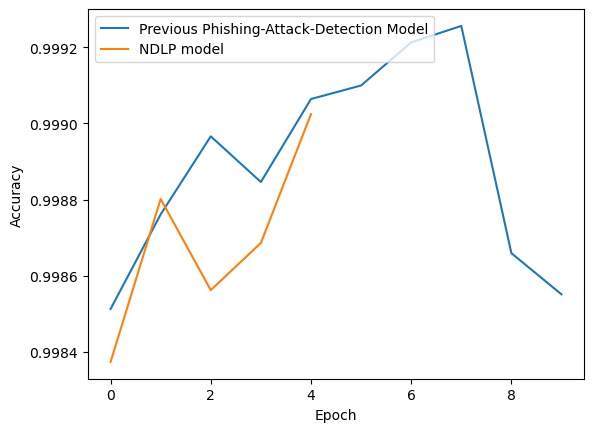

In [28]:
plt.plot(history1.history['auc_1'])
plt.plot(history.history['auc'])
# plt.title('Previous Phishing-Attack-Detection Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Previous Phishing-Attack-Detection Model', 'NDLP model'], loc='upper left')
plt.savefig("Comparative.png", format="png", bbox_inches='tight', dpi=600) # specify filetype explicitly
plt.show()
plt.close()